# GA Data Science (DAT19) - Lab 18

### Working with SQL like a Data Scientist


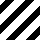
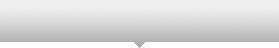
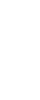
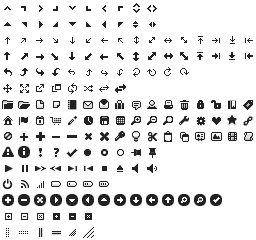
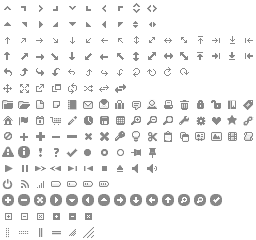
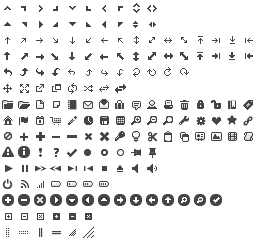
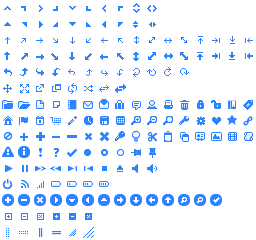
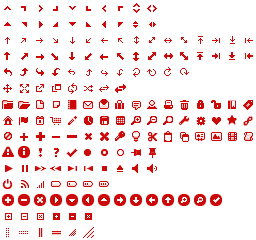
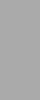
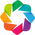
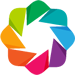
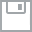
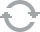
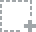
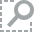
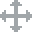
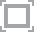
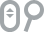

In [4]:
# usual imports
import numpy as np
import matplotlib.pyplot as plt
import pylab as pl
import pandas as pd
from bokeh.plotting import figure,show,output_notebook

output_notebook()
%matplotlib inline

from sklearn.cross_validation import train_test_split
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier

from sklearn.naive_bayes import MultinomialNB
# Each is a different implemntation of a text transform tool: Bag of Words & Tfidf
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer

If you've taken GA's Data Analytics course, this data will look familiar to you. However, what distinguishes data science from data analysis (aside from the machine learning algorithms) is the programmatic approach to working with data. So in order to bring the declarative style of SQL into our procedural world where we transform the data in various steps, we need a method of calling to our database with SQL statements.

Here we will learn how to interact with the SQL database via Python. Data used is from here: http://flowingdata.com/2015/06/05/iowa-liquor-sales-data-3m-rows/

In [2]:
# Use pip install psycopg2 to be able to import this
import psycopg2

from datetime import datetime

In [18]:
conn = psycopg2.connect(database='iowa_liquor_sales_database',user='analytics_student',password='analyticsga',
                        host='analyticsga.cuwj8wuu6wbh.us-west-2.rds.amazonaws.com')

This object is what we call a connection object. It mirrors a common framework of creating a `connection` object used to pass SQL statements. Each kind of database has a driver that maps general requests to the database sqecific API. The GA database is PostgreSQL based and documentation on our connector is here: https://wiki.postgresql.org/wiki/Psycopg2_Tutorial

The credentials here have read-only access (which is ideal) and we'll be sure to set some key parameters here so that you all don't overrun each other.

In [19]:
conn.set_session(isolation_level='READ UNCOMMITTED',readonly=True)

`isolation_level` refers to how everyone looks at a database. If you are doing analytics in a large organization, this is a tag you will add to make sure that IT continues to love you. It means that you will not lock the table, meaning no one else can access the table until you're done. 

This lab will only use basic syntax from SQL query concepts: SELECT, FROM, WHERE, JOIN, and GROUP BY. We will not do nested queries, aliased tables, CASE statements, and other advanced concepts but there are many SQL tutorials out there you are encouraged to explore, starting with SQL Zoo: http://sqlzoo.net/

As a reminder of the basics, all queries getting information require the SELECT and FROM keywords. The order for all the keywords (note that some can be ommitted) is always SELECT then FROM then JOIN then WHERE then GROUP BY.

In [7]:
cursor = conn.cursor()
cursor.execute("""SELECT table_name FROM information_schema.tables
       WHERE table_schema = 'public'""")
print cursor.fetchall()

[('products',), ('stores',), ('counties',), ('sales',)]


NOTE: Do not run `SELECT * FROM SALES` just yet because it is a very large table.


In [9]:
cursor = conn.cursor()
cursor.execute("""SELECT * FROM products""")
print cursor.fetchall()

[(904616, 'MISC. AMERICAN CORDIALS & LIQUEURS', 'Travis Hasse Apple Pie', 305, 'Mhw Ltd', 750, 12, 1, None, '40', datetime.datetime(2009, 2, 11, 0, 0), None, None, '$9.77', Decimal('14.66'), Decimal('117.22')), (904617, 'MISC. IMPORTED CORDIALS & LIQUEURS', "D'aristi Xtabentun", 391, 'Anchor Distilling (preiss Imports)', 750, 12, 1, None, '60', datetime.datetime(2009, 4, 24, 0, 0), None, None, '$14.12', Decimal('21.18'), Decimal('169.40')), (904618, 'PEACH BRANDIES', 'Hiram Walker Peach Brandy', 370, 'Pernod Ricard Usa/austin Nichols', 1000, 12, 1, None, '60', datetime.datetime(2009, 12, 16, 0, 0), None, '89540500867', '$6.50', Decimal('9.74'), Decimal('77.94')), (904619, 'SCOTCH WHISKIES', 'Oak Cross Whisky', 305, 'Mhw Ltd', 750, 6, 1, None, '86', datetime.datetime(2009, 12, 24, 0, 0), None, None, '$25.33', Decimal('38.00'), Decimal('152.00')), (904620, 'FLAVORED VODKA', 'Uv Red(cherry) Vodka', 380, 'Phillips Beverage Company', 200, 24, 1, None, '60', datetime.datetime(2009, 11, 5, 0,

Well that's exciting but rather unusable. If only there existed a way to get the table into a data format we're more familiar with...

In [12]:
products = pd.read_sql('SELECT * FROM products',conn)
products.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9977 entries, 0 to 9976
Data columns (total 16 columns):
item_no             9977 non-null int64
category_name       9860 non-null object
item_description    9977 non-null object
vendor              9977 non-null int64
vendor_name         9977 non-null object
bottle_size         9977 non-null int64
pack                9977 non-null int64
inner_pack          9977 non-null int64
age                 0 non-null object
proof               9977 non-null object
list_date           9977 non-null datetime64[ns]
upc                 3815 non-null object
scc                 5192 non-null object
bottle_price        9969 non-null object
shelf_price         9969 non-null float64
case_cost           9969 non-null float64
dtypes: datetime64[ns](1), float64(2), int64(5), object(8)
memory usage: 1.3+ MB


In [20]:
stores = pd.read_sql('SELECT * FROM stores',conn)
stores.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1973 entries, 0 to 1972
Data columns (total 5 columns):
store            1973 non-null int64
name             1973 non-null object
store_status     1973 non-null object
store_address    1973 non-null object
address_info     11 non-null object
dtypes: int64(1), object(4)
memory usage: 92.5+ KB


In [23]:
stores.store_address[0]

'2217 College\nCedar Falls, IA 506130000\n(42.51716928600007, -92.45583783899997)'

In [21]:
counties = pd.read_sql('SELECT * FROM counties',conn)
counties.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99 entries, 0 to 98
Data columns (total 2 columns):
county        99 non-null object
population    99 non-null int64
dtypes: int64(1), object(1)
memory usage: 2.3+ KB


In [24]:
counties.head()

,county,population
0,Adair,7682
1,Adams,4029
2,Allamakee,14330
3,Appanoose,12884
4,Audubon,6119


We can use aggregate functions to learn some facts about the sales table, such as the number of rows and the time range that the data encompasses.

In [26]:
sales_stats = pd.read_sql('SELECT COUNT(Date) Num_Rows, MAX(DATE) Latest,MIN(DATE) Earliest FROM Sales',conn)
sales_stats

,num_rows,latest,earliest
0,3049913,2015-02-26,2014-01-02


3 Million rows! If you were to load the entire dataset into the notebook, it would take up a very large amount of space (428.8 MB, to be specific)

With a subset, though, we can begin to understand the general structure of the table, with the hopes of extracting only the data we need, in an aggregated form if need be. Lets extract all data where the date is on or after February 1st.

In [39]:
small_sales = pd.read_sql("SELECT * FROM sales WHERE Date >= '2/1/2015'",conn)
small_sales.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 158281 entries, 0 to 158280
Data columns (total 17 columns):
date                 158281 non-null datetime64[ns]
convenience_store    17453 non-null object
store                158281 non-null int64
county_number        158281 non-null object
county               158281 non-null object
category             158281 non-null object
category_name        158280 non-null object
vendor_no            158281 non-null object
vendor               158281 non-null object
item                 158281 non-null int64
description          158281 non-null object
pack                 158281 non-null int64
liter_size           158281 non-null int64
state_btl_cost       158281 non-null object
btl_price            158281 non-null object
bottle_qty           158281 non-null int64
total                158281 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(5), object(10)
memory usage: 21.7+ MB


A note on the data: Iowa liquor is controlled exclusively by the Iowa Alcoholic Beverages Division so state bottle cost is what the division paid for the bottle. The retail is the price it sold the liquor to vendors. Pack is the number of bottles per case. The bottle_qty is the total number of bottles ordered

In [43]:
small_sales

,date,convenience_store,store,county_number,county,category,category_name,vendor_no,vendor,item,description,pack,liter_size,state_btl_cost,btl_price,bottle_qty,total
0,2015-02-26,None,2515,17,Cerro Gordo,1022100,TEQUILA,434,Luxco-St Louis,87937,Juarez Tequila Silver,12,1000,$6.92,$10.38,48,498.24
1,2015-02-26,None,2515,17,Cerro Gordo,1022100,TEQUILA,434,Luxco-St Louis,87938,Juarez Tequila Silver,6,1750,$13.50,$20.25,6,121.50
2,2015-02-26,None,2515,17,Cerro Gordo,1012200,SCOTCH WHISKIES,55,Sazerac North America,8824,Lauder's,24,375,$3.21,$4.82,3,14.46
3,2015-02-26,None,2515,17,Cerro Gordo,1022100,TEQUILA,410,The Patron Spirits Company,88294,Patron Silver Tequila,12,375,$14.00,$21.00,2,42.00
4,2015-02-26,None,2515,17,Cerro Gordo,1022100,TEQUILA,421,"Sazerac Co., Inc.",88767,Tortilla White Tequila,12,1000,$6.64,$9.96,24,239.04
5,2015-02-26,None,2515,17,Cerro Gordo,1022100,TEQUILA,260,Diageo Americas,89175,Don Julio Anejo Tequila,6,750,$32.49,$48.74,2,97.48
6,2015-02-26,None,2515,17,Cerro Gordo,1022100,TEQUILA,434,Luxco-St Louis,89182,El Mayor Reposado,6,750,$13.50,$20.25,2,40.50
7,2015-02-26,None,2515,17,Cerro Gordo,1022100,TEQUILA,395,Proximo,89197,Jose Cuervo Especial Reposado Tequila,12,1000,$12.50,$18.75,12,225.00
8,2015-02-26,None,2515,17,Cerro Gordo,1022100,TEQUILA,395,Proximo,89198,Jose Cuervo Especial Reposado Tequila,6,1750,$20.25,$30.38,6,182.28
9,2015-02-26,None,2515,17,Cerro Gordo,1022100,TEQUILA,395,Proximo,89199,Jose Cuervo Especial Reposado Square,12,375,$5.50,$8.25,2,16.50


A big goal with SQL is to identify the mappings we can do in order to combine our data as `JOINS`. Remember: `JOINS` are ways of linking data using primary and foreign keys. A primary key identifies a row uniquely. A foreign key is used for mapping a row in one table to a primary key in another table.

Think of joins as Venn Diagrams: http://www.codeproject.com/KB/database/Visual_SQL_Joins/Visual_SQL_JOINS_orig.jpg

## Exercise 1

1) What is the primary key of our Counties table? Does it have a corresponding foreign key in another table?

2) Generate a list of all counties that have a population less than 10,000. HINT: Use the WHERE clause

3) Find the February sales for one county with a population below 10,000 within our subset. This will need to use a result from the statement from 2) and a GROUP BY clause in your SQL. This can also be done with pandas using `.groupby`

4) Find the Total Sales for that county (everything in our database). You will need to use SQL to extract the subset you need, since our subset is only for February 2016.

## Getting Fancy

We can begin to understand more about what our Iowans drink using group by statements as well as what the product offerings are. Something that is wonderful about SQL is that it understands math as applied to columns on a row by row basis. So if you notice, the Total column is the product of bottle_qty times bottle_price. What if we wanted to understand more about the total volume sold?

In [47]:
sql_string = '''
SELECT county, AVG(bottle_qty) Num_Bottles, AVG(bottle_qty*liter_size/1000) Liters
FROM sales
GROUP BY county'''
county_volumes =  pd.read_sql(sql_string,conn)
county_volumes

,county,num_bottles,liters
0,Wayne,6.665068,6.502798
1,Montgomery,7.838063,7.261902
2,None,8.745782,5.577661
3,Poweshiek,5.985422,5.626434
4,Story,8.867940,8.424514
5,Calhoun,7.153398,7.173522
6,Dallas,14.975005,16.362885
7,Decatur,7.358510,6.292377
8,Worth,6.674981,6.718883
9,Carroll,10.088183,10.881055


As we get into more complex aggregations, it's good to keep in mind the following aggregation functions: MAX, MIN, AVG, VAR (for variance). 

### Exercise 2


Determine the most popular alcohol sold, by sales

Determine the most popular alcohol sold, by volume.

Which liquor costs the most per liter? (don't forget the products table!)

### Bonus!

Can you graph the Sales per month over time?